In [1]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\

In [2]:
ee.Initialize()

In [3]:
# define the year-range
year = [f'{i}_{i+2}' for i in range(1990,2020,3)]
year_img_val_dict = {yr:i for yr,i in zip(year,range(10,0,-1))}

# get all possible years for traning the projection
proj_yr = []
for k,v in year_img_val_dict.items():
    # get the t0 val/img
    t0 = k
        
    # get the t1;t2
    if v == 2:
        pass
    else:
        for val in range(v-1,1,-1):
            prj_val = val - (v - val)
            
            if  prj_val>0:
                
                prj_yr  = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                
                t1 = [k for k,v in year_img_val_dict.items() if v==val][0]
                t2 = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                                
                proj_yr.append((t0,t1,t2))

##### Read AUC dfs

In [4]:
# read tranditional-way AUC
dfs = [pd.read_pickle(f) for f in glob.glob('./Result/old_school_way/*.pkl')]
AUC_factors = pd.concat(dfs)
AUC_factors = AUC_factors[['t0', 't1', 't2','DEM', 'SLOPE', 'Distance', 'y_true', 'y_prob']]


# read FCNN AUC dfs
AUC_FCNN = pd.read_pickle(f'./Result/AUC_TRAINING/AUC_metrics.pkl')
AUC_FCNN = AUC_FCNN[AUC_FCNN['Model']!='Distance']
AUC_FCNN = AUC_FCNN[['t0', 't1', 't2', 'Model', 'Seed', 'Y_true', 'Y_prob']]
AUC_FCNN.columns = ['t0', 't1', 't2', 'Model', 'Seed', 'y_true', 'y_prob']

##### Compute the APS

In [5]:
# compute the APS
AUC_factors['APS']      = AUC_factors.apply(lambda x: metrics.average_precision_score(x['y_true'],x['y_prob']),axis=1)
AUC_FCNN['APS']         = AUC_FCNN.apply(lambda x: metrics.average_precision_score(x['y_true'],x['y_prob']),axis=1)

In [6]:
# compute the total area of the research area
mask = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992/Control_1990_1992_0").gt(-1)
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward").updateMask(mask)
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

area = urban.reduceRegion(    reducer=ee.Reducer.frequencyHistogram(),
                              geometry=region.geometry().bounds(),
                              scale=30,
                              maxPixels=int(1e13)).getInfo() 
area_sum = np.array([v for (k,v) in area['b1'].items()]).sum()

# compute the base-APS, which is the result of expansion_area/total_area
Area_expansion = pd.read_csv('./Result/AUC_TRAINING/Area_expansion.csv')
Area_expansion = Area_expansion[Area_expansion['expansion_type']=='pred']
Area_expansion['Expansion_ratio'] = Area_expansion['count']/area_sum
Area_expansion = Area_expansion[['t0', 't1', 't2', 'Expansion_ratio']]

In [7]:
# add the expansion_ratio to AUC_df
AUC_factors = pd.merge(AUC_factors,Area_expansion,how='left',left_on=['t0', 't1', 't2'],right_on = ['t0', 't1', 't2'])
AUC_FCNN    = pd.merge(AUC_FCNN,Area_expansion,how='left',left_on=['t0', 't1', 't2'],right_on = ['t0', 't1', 't2'])

AUC_factors['X_label'] = AUC_factors.apply(lambda x: f"{x['t0']}_and_{x['t1']}_prj_{x['t2']}",axis=1)
AUC_FCNN['X_label']    = AUC_FCNN.apply(lambda x: f"{x['t0']}_and_{x['t1']}_prj_{x['t2']}",axis=1)

In [8]:
target_prj = '1990_1992_and_2002_2004_prj_2014_2016'

In [10]:
AUC_factors_selected = AUC_factors[AUC_factors['X_label']==target_prj]
AUC_FCNN_selected    = AUC_FCNN[AUC_FCNN['X_label']==target_prj]

<AxesSubplot:xlabel='X_label', ylabel='APS'>

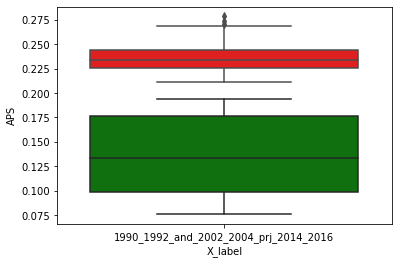

In [18]:
sns.boxplot(data=AUC_factors_selected,x='X_label',y='APS',color='g')
sns.boxplot(data=AUC_FCNN_selected,x='X_label',y='APS',color='r')